# 套利分析

In [37]:
%matplotlib inline

In [38]:
import ccxt.async as ccxt
import urllib.error
import requests
import asyncio
import time
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np

In [39]:
SYMBOL = 'ETH/BTC'

In [43]:
def get_all_exchange():
    return [getattr(ccxt,name)() for name in ccxt.exchanges]

In [6]:
def unzip(l): 
    return list(zip(*l))

In [17]:
async def get_order_books(exchange_list, symbol):
    res = {}
    for exchange in exchange_list:
        res[exchange.id] = await exchange.fetch_order_book(symbol) 
    return res

In [20]:
def process_order_book(order_book):
    result = order_book.copy()
    result['asks'] = pd.DataFrame(data = {'price':list(unzip(order_book['asks']))[0], 
                                              'volume': list(unzip(order_book['asks']))[1]})
    result['bids'] = pd.DataFrame(data = {'price':list(unzip(order_book['bids']))[0], 
                                              'volume': list(unzip(order_book['bids']))[1]})
    return result

In [21]:
orders_list = asyncio.get_event_loop().run_until_complete(get_order_books([ccxt.huobipro(), ccxt.okex()], SYMBOL))

In [22]:
orders_hobipro,  orders_okex = (process_order_book(orders_list['huobipro']), 
                               process_order_book(orders_list['okex']))

In [23]:
orders_hobipro['asks'].head()

,price,volume
0,0.081040,1.0000
1,0.081041,2.3529
2,0.081045,13.0065
3,0.081047,0.9068
4,0.081075,10.1790


In [24]:
orders_hobipro['bids'].head()

,price,volume
0,0.081020,0.4889
1,0.081019,0.6982
2,0.080997,0.0020
3,0.080975,2.4016
4,0.080974,0.1000


## 火币网和 OKEX 'ETH/BTC' 的交易盘

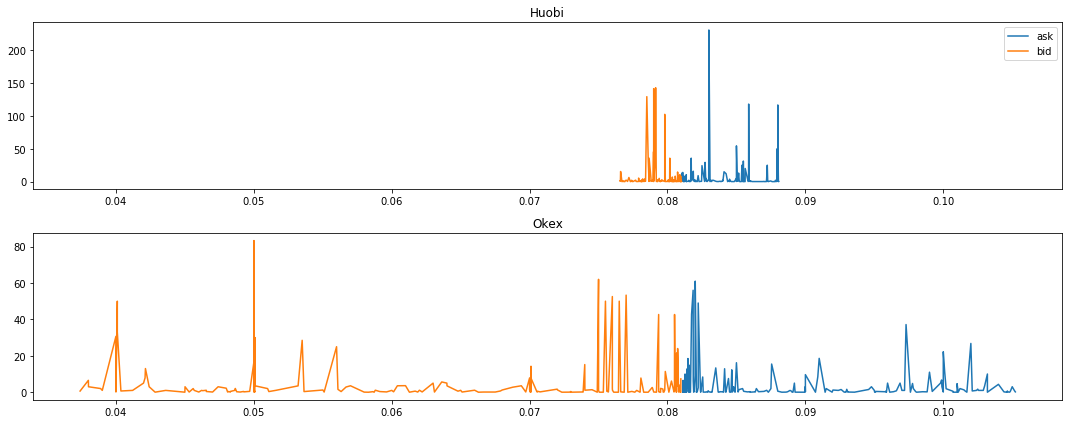

In [25]:
plt.figure(figsize=(15, 6)) 

ax = plt.subplot(212, )
plt.plot(orders_okex['asks']['price'],orders_okex['asks']['volume'], label = 'ask')  
plt.plot(orders_okex['bids']['price'],orders_okex['bids']['volume'], label = 'bid')  
#plt.legend()
plt.title('Okex')
plt.subplot(211,sharex=ax)
plt.plot(orders_hobipro['asks']['price'],orders_hobipro['asks']['volume'], label = 'ask')  
plt.plot(orders_hobipro['bids']['price'],orders_hobipro['bids']['volume'], label = 'bid')  
plt.legend()
plt.title('Huobi')
plt.tight_layout()
plt.show()  

## 计算两个交易所之间的价差

In [27]:
async def difference_between_two_exchange(ex1, ex2, symbol,t = 10):   
    ex1_bids = []
    ex2_bids = []
    ex1_asks = []
    ex2_asks = []
    for i in range(t):
        ex1_order_book = await ex1.fetch_order_book(symbol)
        ex2_order_book = await ex2.fetch_order_book(symbol)
        ex1_bids.append(ex1_order_book['bids'][0][0])
        ex2_bids.append(ex2_order_book['bids'][0][0])
        ex1_asks.append(ex1_order_book['asks'][0][0])
        ex2_asks.append(ex2_order_book['asks'][0][0])
        await asyncio.sleep(1)
    ex1_bids = np.array(ex1_bids)
    ex2_bids = np.array(ex2_bids) 
    ex1_asks = np.array(ex1_asks) 
    ex2_asks = np.array(ex2_asks)
    
    return {'dbids': ex1_bids - ex2_bids,
            'dasks': ex1_asks - ex2_asks,
            'dbidask':ex1_bids - ex2_asks,
            'daskbid':ex1_asks - ex2_bids}

## 将火币和 OKEX 的 ‘ETH/BTC’ 价格进行比较
时间为 10s

In [28]:
r = asyncio.get_event_loop().run_until_complete(
    difference_between_two_exchange(ccxt.huobipro(), ccxt.okex(), SYMBOL, t = 10))

okex requires to release all resources with an explicit call to the .close() coroutine.
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x1199d7048>
huobipro requires to release all resources with an explicit call to the .close() coroutine.
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x1199e75c0>
okex requires to release all resources with an explicit call to the .close() coroutine.
huobipro requires to release all resources with an explicit call to the .close() coroutine.
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x119d90160>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x119d80710>


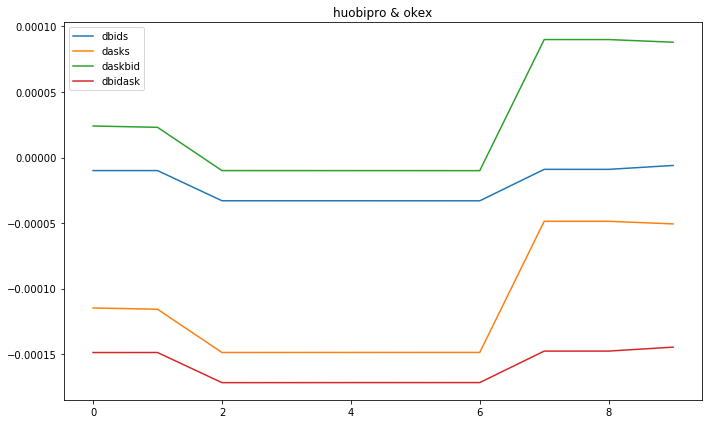

In [29]:
plt.figure(figsize=(10, 6)) 
plt.plot(r['dbids'], label = 'dbids')  
plt.plot(r['dasks'], label = 'dasks')  
plt.plot(r['daskbid'], label = 'daskbid')  
plt.plot(r['dbidask'], label = 'dbidask')  
plt.legend()
plt.title('huobipro & okex')
plt.tight_layout()
plt.show()

## 补充
Jupyter notebook 对异步的支持不是很好，所以所有交易所之间的套利得用一个单独的python文件写